In [11]:
import pandas as pd

# =======================
# CONFIGURATION
# =======================
file_path = '/Users/user/Event-data/Men/2025-2026/Belgium/Anderlecht 5-2 Westerlo.csv'
output_path = '/Users/user/possession_analysis_percentage.xlsx'

# Weights
weights = {
    'goals': 0.35,
    'shots': 0.20,
    'final_third_entry': 0.15,
    'progressive_passes': 0.15
}

# Event type mapping
event_type_map = {
    1: 'Pass', 2: 'Offside Pass', 3: 'Take On', 4: 'Foul', 5: 'Out',
    6: 'Corner Awarded', 7: 'Tackle', 8: 'Interception', 9: 'Turnover',
    10: 'Save', 11: 'Claim', 12: 'Clearance', 13: 'Miss', 14: 'Post',
    15: 'Attempt Saved', 16: 'Goal', 17: 'Card', 18: 'Player off', 19: 'Player on'
}

# =======================
# STEP 1: Load Data
# =======================
data = pd.read_csv(file_path)
data['eventName'] = data['typeId'].map(event_type_map).fillna('Other')
data['time'] = data['timeMin'] * 60 + data['timeSec']
data = data.sort_values(by=['periodId', 'time']).reset_index(drop=True)

# =======================
# STEP 2: Build Possession Chains
# =======================
possessions = []
current_team = None
possession_events = []

for _, row in data.iterrows():
    event_team = row['contestantId']
    event_type = row['eventName']

    if current_team is None:
        current_team = event_team
        possession_events = [row]
        continue

    if event_team == current_team and event_type not in ['MatchEnd', 'MatchStart']:
        possession_events.append(row)
    else:
        if possession_events:
            possessions.append({'team': current_team, 'events': possession_events})
        if event_type not in ['MatchEnd', 'MatchStart']:
            current_team = event_team
            possession_events = [row]
        else:
            current_team = None
            possession_events = []

# =======================
# STEP 3: Metrics per Possession
# =======================
possession_metrics = []
for pos in possessions:
    team = pos['team']
    events = pd.DataFrame(pos['events'])
    
    successful_passes = len(events[(events['typeId'] == 1) & (events['outcome'] == 1)])
    shots = len(events[events['typeId'].isin([13, 14, 15, 16])])
    goals = len(events[events['typeId'] == 16])
    final_third = any(events['x'] > 66)

    progressive_passes = 0
    pass_events = events[(events['typeId'] == 1) & (events['outcome'] == 1)]
    if not pass_events.empty:
        previous_x = None
        for _, pe in pass_events.iterrows():
            if previous_x is not None and pe['x'] > previous_x + 20:
                progressive_passes += 1
            previous_x = pe['x']

    possession_metrics.append({
        'team': team,
        'shots': shots,
        'goals': goals,
        'final_third_entry': 1 if final_third else 0,
        'progressive_passes': progressive_passes
    })

possession_df = pd.DataFrame(possession_metrics)

# =======================
# STEP 4: Aggregate Per Team
# =======================
team_agg = possession_df.groupby('team').agg({
    'shots': 'sum',
    'goals': 'sum',
    'final_third_entry': 'sum',
    'progressive_passes': 'sum'
}).reset_index()

# =======================
# STEP 5: Compute Percentages and Weighted Score
# =======================
# Compute percentage share for each component
for col in ['goals', 'shots', 'final_third_entry', 'progressive_passes']:
    total = team_agg[col].sum()
    team_agg[col + '_%'] = (team_agg[col] / total) * 100 if total > 0 else 0

# Weighted contribution (component% * weight)
team_agg['weighted_sum'] = (
    team_agg['goals_%'] * weights['goals'] +
    team_agg['shots_%'] * weights['shots'] +
    team_agg['final_third_entry_%'] * weights['final_third_entry'] +
    team_agg['progressive_passes_%'] * weights['progressive_passes']
)

# Final PUS = weighted_sum / 4
team_agg['PUS'] = team_agg['weighted_sum']

# =======================
# STEP 6: Output Table
# =======================
columns_order = [
    'team', 'goals', 'goals_%', 'shots', 'shots_%',
    'final_third_entry', 'final_third_entry_%',
    'progressive_passes', 'progressive_passes_%',
    'PUS'
]
team_agg = team_agg[columns_order]

# =======================
# STEP 7: Export to Excel
# =======================
with pd.ExcelWriter(output_path) as writer:
    team_agg.to_excel(writer, sheet_name='PUS Breakdown', index=False)
    possession_df.to_excel(writer, sheet_name='Raw Possessions', index=False)

print(f"✅ Export completed: {output_path}")


✅ Export completed: /Users/user/possession_analysis_percentage.xlsx


In [13]:
plt.figure(figsize=(8, 5))
colors = [team_colors[t] for t in team_agg['team']]
plt.bar(team_agg['team'], team_agg['PUS'], color=colors)
plt.title('Possession Utilisation Score (PUS)', fontsize=14)
plt.ylabel('PUS (%)')
plt.ylim(0, 100)
for i, v in enumerate(team_agg['PUS']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
plt.show()


NameError: name 'team_colors' is not defined

<Figure size 800x500 with 0 Axes>

✅ Export completed: /Users/user/possession_analysis_percentage.xlsx


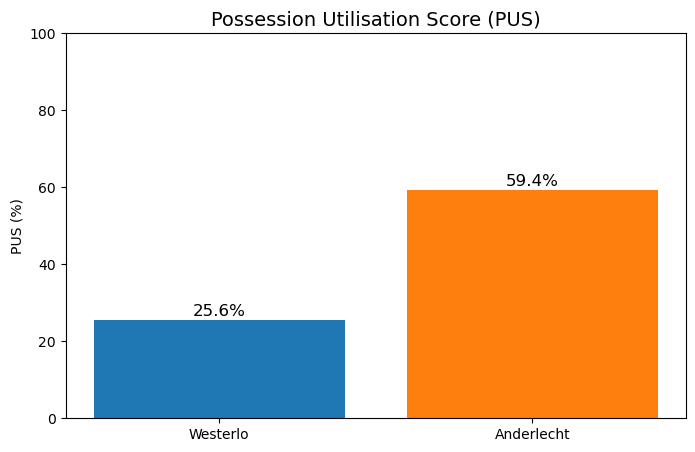

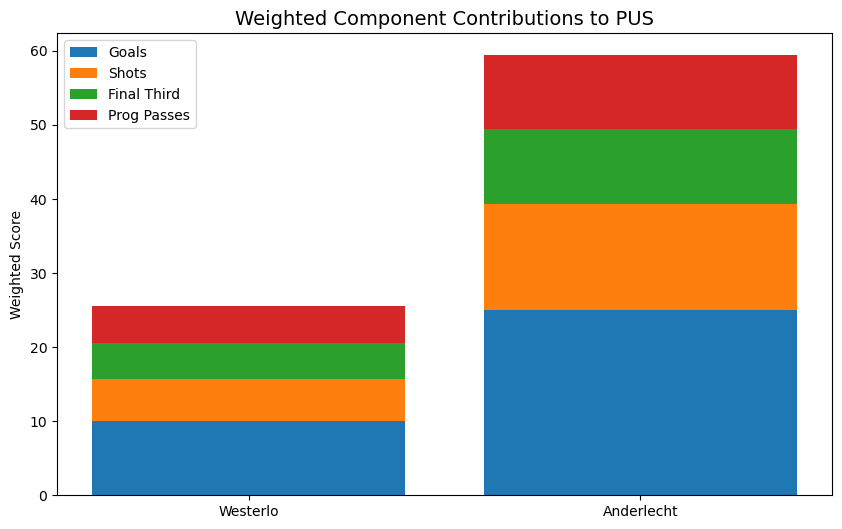

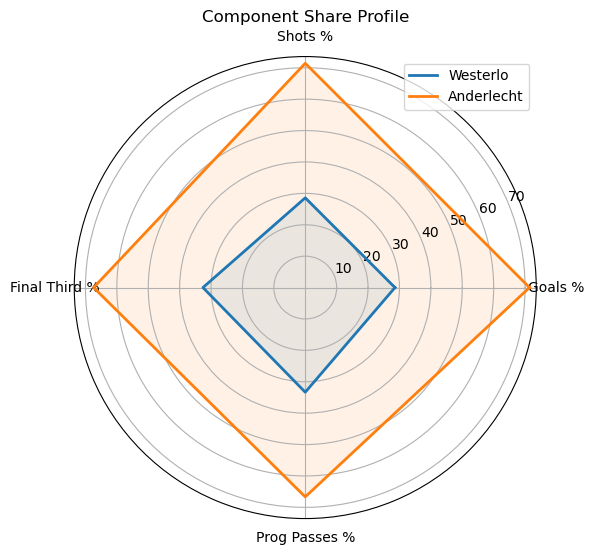

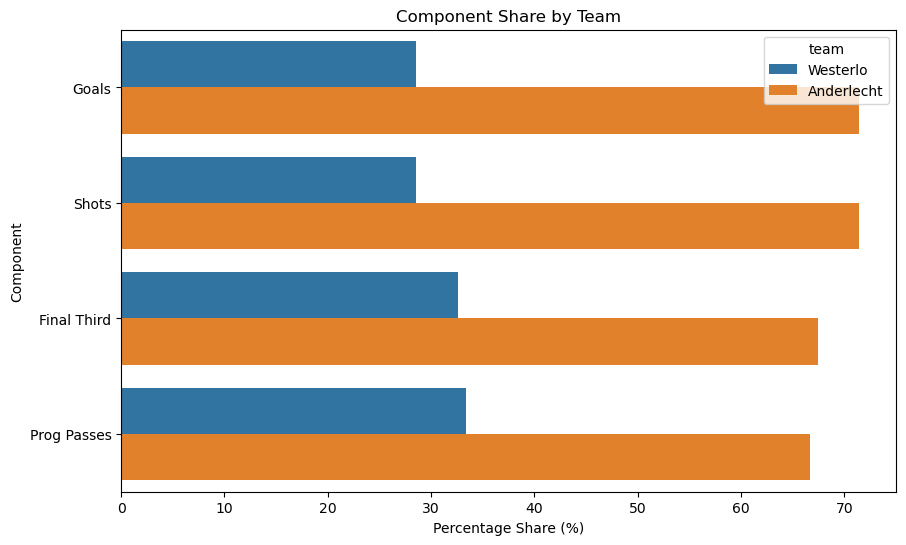

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# =======================
# CONFIGURATION
# =======================
file_path = '/Users/user/Event-data/Men/2025-2026/Belgium/Anderlecht 5-2 Westerlo.csv'
output_path = '/Users/user/possession_analysis_percentage.xlsx'

# Weights for PUS calculation
weights = {
    'goals': 0.35,
    'shots': 0.20,
    'final_third_entry': 0.15,
    'progressive_passes': 0.15
}

# Event type mapping
event_type_map = {
    1: 'Pass', 2: 'Offside Pass', 3: 'Take On', 4: 'Foul', 5: 'Out',
    6: 'Corner Awarded', 7: 'Tackle', 8: 'Interception', 9: 'Turnover',
    10: 'Save', 11: 'Claim', 12: 'Clearance', 13: 'Miss', 14: 'Post',
    15: 'Attempt Saved', 16: 'Goal', 17: 'Card', 18: 'Player off', 19: 'Player on'
}

# Map contestant IDs to team names
team_mapping = {
    "6vyr13j6kbwdtxjwm1m4m8nu2": 'Anderlecht',  # Replace with actual ID for Anderlecht
    "2nhn3ikl1ciq34w3hcp883d6p": 'Westerlo'     # Replace with actual ID for Westerlo
}

# Colors for visuals
team_colors = {
    'Anderlecht': '#ff7f0e',  # Orange
    'Westerlo': '#1f77b4'     # Blue
}

# =======================
# STEP 1: Load and Prepare Data
# =======================
data = pd.read_csv(file_path)
data['eventName'] = data['typeId'].map(event_type_map).fillna('Other')
data['time'] = data['timeMin'] * 60 + data['timeSec']
data['team_name'] = data['contestantId'].map(team_mapping)
data = data.sort_values(by=['periodId', 'time']).reset_index(drop=True)

# =======================
# STEP 2: Build Possession Chains
# =======================
possessions = []
current_team = None
possession_events = []

for _, row in data.iterrows():
    event_team = row['contestantId']
    event_type = row['eventName']

    if current_team is None:
        current_team = event_team
        possession_events = [row]
        continue

    if event_team == current_team and event_type not in ['MatchEnd', 'MatchStart']:
        possession_events.append(row)
    else:
        if possession_events:
            possessions.append({'team': current_team, 'events': possession_events})
        if event_type not in ['MatchEnd', 'MatchStart']:
            current_team = event_team
            possession_events = [row]
        else:
            current_team = None
            possession_events = []

# =======================
# STEP 3: Metrics per Possession
# =======================
possession_metrics = []
for pos in possessions:
    team = pos['team']
    events = pd.DataFrame(pos['events'])
    
    shots = len(events[events['typeId'].isin([13, 14, 15, 16])])
    goals = len(events[events['typeId'] == 16])
    final_third = any(events['x'] > 66)
    
    progressive_passes = 0
    pass_events = events[(events['typeId'] == 1) & (events['outcome'] == 1)]
    if not pass_events.empty:
        previous_x = None
        for _, pe in pass_events.iterrows():
            if previous_x is not None and pe['x'] > previous_x + 20:
                progressive_passes += 1
            previous_x = pe['x']

    possession_metrics.append({
        'team': team,
        'shots': shots,
        'goals': goals,
        'final_third_entry': 1 if final_third else 0,
        'progressive_passes': progressive_passes
    })

possession_df = pd.DataFrame(possession_metrics)

# =======================
# STEP 4: Aggregate Per Team
# =======================
team_agg = possession_df.groupby('team').agg({
    'shots': 'sum',
    'goals': 'sum',
    'final_third_entry': 'sum',
    'progressive_passes': 'sum'
}).reset_index()

team_agg['team'] = team_agg['team'].map(team_mapping)

# =======================
# STEP 5: Compute Percentages and PUS
# =======================
# Percentages for each component
for col in ['goals', 'shots', 'final_third_entry', 'progressive_passes']:
    total = team_agg[col].sum()
    team_agg[col + '_%'] = (team_agg[col] / total) * 100 if total > 0 else 0

# Weighted sum (final PUS)
team_agg['PUS'] = (
    team_agg['goals_%'] * weights['goals'] +
    team_agg['shots_%'] * weights['shots'] +
    team_agg['final_third_entry_%'] * weights['final_third_entry'] +
    team_agg['progressive_passes_%'] * weights['progressive_passes']
)

# =======================
# STEP 6: Prepare Excel Output
# =======================
columns_order = [
    'team', 'goals', 'goals_%', 'shots', 'shots_%',
    'final_third_entry', 'final_third_entry_%',
    'progressive_passes', 'progressive_passes_%', 'PUS'
]
team_agg = team_agg[columns_order]

with pd.ExcelWriter(output_path) as writer:
    team_agg.to_excel(writer, sheet_name='PUS Breakdown', index=False)
    possession_df.to_excel(writer, sheet_name='Raw Possessions', index=False)

print(f"✅ Export completed: {output_path}")

# =======================
# VISUALIZATIONS
# =======================
# Visual 1: PUS Bar Chart
plt.figure(figsize=(8, 5))
colors = [team_colors[t] for t in team_agg['team']]
plt.bar(team_agg['team'], team_agg['PUS'], color=colors)
plt.title('Possession Utilisation Score (PUS)', fontsize=14)
plt.ylabel('PUS (%)')
plt.ylim(0, 100)
for i, v in enumerate(team_agg['PUS']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
plt.show()

# Visual 2: Stacked Bar – Weighted Contributions
components = ['goals_%', 'shots_%', 'final_third_entry_%', 'progressive_passes_%']
labels = ['Goals', 'Shots', 'Final Third', 'Prog Passes']
weights_list = [weights['goals'], weights['shots'], weights['final_third_entry'], weights['progressive_passes']]
weighted_values = team_agg[components].mul(weights_list, axis=1)

plt.figure(figsize=(10, 6))
bottom = [0] * len(team_agg)
for i, label in enumerate(labels):
    plt.bar(team_agg['team'], weighted_values.iloc[:, i], bottom=bottom, label=label)
    bottom = [bottom[j] + weighted_values.iloc[j, i] for j in range(len(bottom))]
plt.title('Weighted Component Contributions to PUS', fontsize=14)
plt.ylabel('Weighted Score')
plt.legend()
plt.show()

# Visual 3: Radar Chart – Component % Profile
categories = ['Goals %', 'Shots %', 'Final Third %', 'Prog Passes %']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for i, row in team_agg.iterrows():
    values = [row['goals_%'], row['shots_%'], row['final_third_entry_%'], row['progressive_passes_%']]
    values += values[:1]
    ax.plot(angles, values, color=team_colors[row['team']], linewidth=2, label=row['team'])
    ax.fill(angles, values, color=team_colors[row['team']], alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title('Component Share Profile')
plt.legend(loc='upper right')
plt.show()

# Visual 4: Horizontal Bar – Component Share by Team
contrib_df = team_agg.melt(id_vars='team', value_vars=components, var_name='Component', value_name='Percent')
contrib_df['Component'] = contrib_df['Component'].map({
    'goals_%': 'Goals',
    'shots_%': 'Shots',
    'final_third_entry_%': 'Final Third',
    'progressive_passes_%': 'Prog Passes'
})

plt.figure(figsize=(10, 6))
sns.barplot(data=contrib_df, x='Percent', y='Component', hue='team', palette=team_colors)
plt.title('Component Share by Team')
plt.xlabel('Percentage Share (%)')
plt.show()
